<a href="https://colab.research.google.com/github/wynn918/ML/blob/main/Fill_missing_value_RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
boston = load_boston()
regressor = RandomForestRegressor(n_estimators=100,random_state=0)
cross_val_score(regressor, boston.data, boston.target, cv=10
               ,scoring = "neg_mean_squared_error")

array([-10.72900447,  -5.36049859,  -4.74614178, -20.84946337,
       -12.23497347, -17.99274635,  -6.8952756 , -93.78884428,
       -29.80411702, -15.25776814])

In [ ]:
#the modle evaulation score list from sklearn 
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [15]:
# Using random forest regressor fill the missing value
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [8]:
dataset=load_boston()
dataset.data.shape

(506, 13)

In [ ]:
dataset.data

In [9]:
x_full,y_full=dataset.data, dataset.target
n_samples=x_full.shape[0]
n_features=x_full.shape[1]

In [10]:
# Assume the missing vlaue account for 50%，then total 3289 missing data
rng=np.random.RandomState(0)
missing_rate=0.5
n_missing_samples=int(np.floor(n_samples * n_features * missing_rate)) #np.floor: take a small integer
n_missing_samples

3289

In [11]:
#Creat an array with 3289 data distribute in column index 0~13 and row index 0~506
missing_features=rng.randint(0,n_features,n_missing_samples)
missing_samples=rng.randint(0,n_samples,n_missing_samples)
x_missing=x_full.copy()
y_missing=y_full.copy()# Y cann't be missing, it's the target
x_missing[missing_samples,missing_features]=np.nan
x_missing=pd.DataFrame(x_missing)
x_missing.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.9,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN


In [21]:
print(len(missing_features))
print(len(missing_samples))

3289
3289


In [12]:
# Using 0 and mean fill the missing value
imp_0=SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
x_missing_0=imp_0.fit_transform(x_missing)

from sklearn.impute import SimpleImputer
imp_mean=SimpleImputer(missing_values=np.nan, strategy='mean')
x_missing_mean=imp_mean.fit_transform(x_missing)

pd.DataFrame(x_missing_0).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [13]:
# Using random forest regressor fill the missing value
x_missing_reg=x_missing.copy()

# Find the order of missing value number from small to big
sortindex=np.argsort(x_missing_reg.isnull().sum(axis=0)).values

In [25]:
for i in sortindex:

  df = x_missing_reg
  fillc = df.iloc[:,i]
  df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)

  df_0 =SimpleImputer(missing_values=np.nan,
                        strategy='constant',fill_value=0).fit_transform(df)
              
  Ytrain = fillc[fillc.notnull()] 
  Ytest = fillc[fillc.isnull()] #need to know the index of missing value
  Xtrain = df_0[Ytrain.index,:] 
  Xtest = df_0[Ytest.index,:]

  rfc = RandomForestRegressor(n_estimators=100)
  rfc = rfc.fit(Xtrain, Ytrain)
  Ypredict = rfc.predict(Xtest)

  x_missing_reg.loc[x_missing_reg.iloc[:,i].isnull(),i] = Ypredict

In [28]:
X=[x_full, x_missing_mean,x_missing_0,x_missing_reg]

mse=[]

for x in X:
  estimator=RandomForestRegressor(random_state=0, n_estimators=100)
  scores=cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error',cv=5).mean()
  mse.append(scores*-1)


In [29]:
[*zip(['x_full','x_missing_mean','x_missing_0','x_missing_reg'],mse)]

[('x_full', 21.62860460743544),
 ('x_missing_mean', 40.84405476955929),
 ('x_missing_0', 49.50657028893417),
 ('x_missing_reg', 19.420835493205196)]

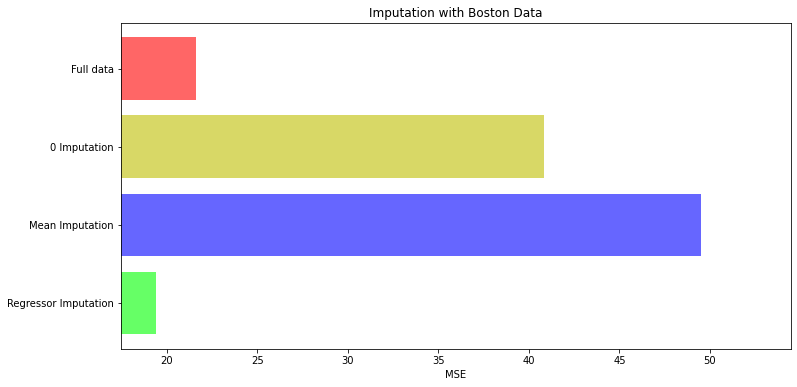

In [31]:
x_labels=['Full data',
          '0 Imputation',
          'Mean Imputation',
          'Regressor Imputation']
colors=['r','y','b','lime']

plt.figure(figsize=(12,6))
ax=plt.subplot(111)#add the sub plot

for i in np.arange(len(mse)):
  ax.barh(i,mse[i],color=colors[i],alpha=0.6,align='center')# add the bar chat in horizontal direction, alpha: the bar thickness

ax.set_title('Imputation with Boston Data')
ax.set_xlim(left=np.min(mse)*0.9,
            right=np.max(mse)*1.1) #xlim：Interval of the X-axis
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.invert_yaxis() #Inverted y axis
ax.set_yticklabels(x_labels)
plt.show()